# Area under the curve

In [26]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

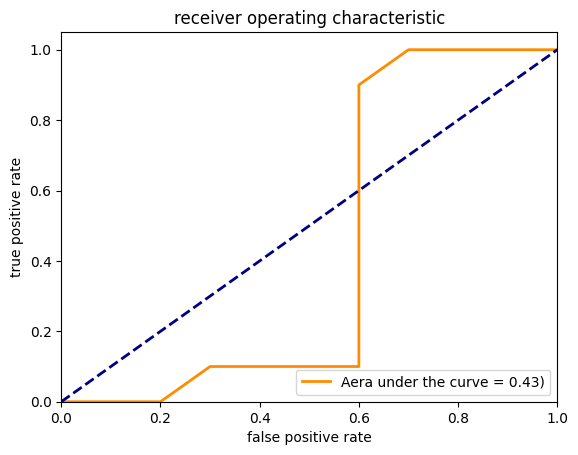

In [27]:
truth = np.array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
predicted_scores = np.array([0.85, 0.3, 0.35, 0.6, 0.55, 0.65, 0.4, 0.5, 0.45, 0.55, 0.75, 0.85, 0.95, 0.1, 0.2, 0.15, 0.9, 0.7, 0.8, 0.3])

fpr, tpr, thresholds = roc_curve(truth, predicted_scores)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'Aera under the curve = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.title('receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()


# MNIST classification


## Imports

In [28]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder

In [29]:
import struct

def read_idx(filename):
    with open(filename, 'rb') as f:
        zero, data_type, dims = struct.unpack('>HBB', f.read(4))  
        shape = tuple(struct.unpack('>I', f.read(4))[0] for d in range(dims))  
        return np.frombuffer(f.read(), dtype=np.uint8).reshape(shape)  

train_images = read_idx('MNIST/train-images.idx3-ubyte')  
train_labels = read_idx('MNIST/train-labels.idx1-ubyte')  
test_images = read_idx('MNIST/t10k-images.idx3-ubyte')    
test_labels = read_idx('MNIST/t10k-labels.idx1-ubyte')    

train_images = train_images / 255.0
test_images = test_images / 255.0

train_images = torch.tensor(train_images, dtype=torch.float32).unsqueeze(1)  
train_labels = torch.tensor(train_labels, dtype=torch.long)
test_images = torch.tensor(test_images, dtype=torch.float32).unsqueeze(1)  
test_labels = torch.tensor(test_labels, dtype=torch.long)

## Making the dataset

In [30]:
class MNISTDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        
        if self.transform:
            image = self.transform(image)
        
        return image, label

transform = transforms.Compose([
    transforms.Normalize((0.1307,), (0.3081,)) 
])

train_dataset = MNISTDataset(train_images, train_labels, transform=transform)
test_dataset = MNISTDataset(test_images, test_labels, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1000, shuffle=False)

## Make the network

In [31]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(28*28, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = x.view(-1, 28*28) 
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return torch.softmax(x, dim=1)

model = Net()
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)



## Training

In [32]:
epochs = 5
for epoch in range(epochs):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

    print(f'Epoch {epoch+1}/{epochs}, Loss: {loss.item()}')



Epoch 1/5, Loss: -0.9164618849754333
Epoch 2/5, Loss: -0.9995919466018677
Epoch 3/5, Loss: -0.9163119196891785
Epoch 4/5, Loss: -0.9683030843734741
Epoch 5/5, Loss: -0.9457923769950867


## Testing

In [33]:
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for data, target in test_loader:
        output = model(data)
        _, predicted = torch.max(output.data, 1)
        total += target.size(0)
        correct += (predicted == target).sum().item()

print(f'{100 * correct / total} %')

96.74 %
